Read in 1460000 Ly-a forest pixels
ColDefs(
    name = 'pos'; format = '3E'
    name = 'vel'; format = '3E'
    name = 'mfof_hiz'; format = 'E'
    name = 'mfof_loz'; format = 'E'
    name = 'igrp_hiz'; format = 'J'
    name = 'igrp_loz'; format = 'J'
    name = 'flux_z'; format = 'E'
    name = 'flux_r'; format = 'E'
    name = 'rho_z'; format = 'E'
    name = 'rho_r'; format = 'E'
    name = 'mstar'; format = 'E'
    name = 'm180bhiz'; format = 'E'
    name = 'm180bloz'; format = 'E'
)


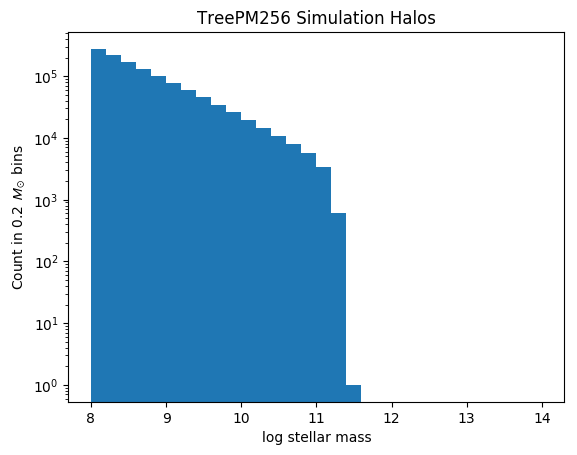

In [1]:
import numpy as np
import time as time
import lyafxcorr_kg as xcorr

# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib as mpl
mpl.rc('mathtext',fontset='stixsans')
mpl.rc('figure', facecolor="white")
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
#import matplotlib.colors as colors
%matplotlib inline

from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord

np.random.seed(45429071)

# Define cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.31)
zmin = 2.0
zmid = 2.3
comdist_mean = cosmo.comoving_distance(zmid)
comdist_zmin = cosmo.comoving_distance(zmin)
dcomdist_dz = cosmo.inv_efunc(zmid) *2998. # in Mpc/h

# Read mock LyaF sightlines
lyapix = xcorr.lyapix("mocks/pixel_radecz_mock_Proto128.bin")
print("Read in %i Ly-a forest pixels" % lyapix.npix)
npix = lyapix.npix

PiBin_fil  = 'bins23_pi_0-30hMpc.txt'
SigBin_fil = 'bins10_sigma_0-30hMpc.txt'

PiBins0 = ascii.read(PiBin_fil)
SigBins0 = ascii.read(SigBin_fil)

PiEdges = PiBins0['pi_edges'].data
SigEdges = SigBins0['sigma_edges'].data

# Convert bin boundaries from Mpc/h to Mpc
PiEdges  = PiEdges/(len(PiEdges)*[cosmo.h])
SigEdges = SigEdges/(len(SigEdges)*[cosmo.h])

PiBound = (min(PiEdges), max(PiEdges) )

# Read halo catalog'
zbox=2.5
Lbox=256.
halofil = '/Users/kheegan/scratch/planck_sim/halo_summary.fits'
halocat0 = fits.open(halofil)
print(halocat0[1].columns)
halocat = halocat0[1].data
halocat0.close()
    
halocat = halocat[1:]

smass = np.asarray(halocat['mstar'].data)/cosmo.h 
log_smass = np.log10(smass)

min_mstar = 8.
max_mstar = 14.

fig, ax = plt.subplots()
binsize=0.2

histbins = np.arange(min_mstar,max_mstar+binsize, binsize)
#print(histbins)
ax.hist(log_smass, bins=histbins, weights=np.ones(np.shape(smass),dtype='float'))
ax.set_yscale('log')
ax.set_xlabel('log stellar mass')
ax.set_ylabel(r'Count in 0.2 $M_\odot$ bins')

ax.set_title('TreePM256 Simulation Halos')
plt.show()

Grab galaxies at 0<[x,y]<128 with stellar masses log10(M_star)~9.5-10.5. The relative distribution within this range is not changed for now... need to change to a Gaussian (or whatever) later! 

In [2]:
pos = halocat['pos'].data
vel = halocat['vel'].data

xpos = (np.asarray(pos)[:,0])*Lbox
ypos = (np.asarray(pos)[:,1])*Lbox
zpos = (np.asarray(pos)[:,2] + (1.+zbox)*np.asarray(vel)[:,2])*Lbox

getgal = np.all(np.column_stack([(xpos > 0.), (xpos <128.),
                                (ypos > 0.), (ypos<128.),
                                (log_smass > 9.5), (log_smass < 11.)]), axis=1)

xgal = xpos[getgal]
ygal = ypos[getgal]
zgal = zpos[getgal]
lgsmass = log_smass[getgal]

print("{} galaxies selected within sim volume".format(len(zgal)))

ra_gal = xgal/comdist_mean.value/cosmo.h * 180./np.pi
dec_gal = ygal/comdist_mean.value/cosmo.h * 180./np.pi
red_gal = zmin + zgal/dcomdist_dz

33554 galaxies selected within sim volume


Select protocluster galaxies and define control sample

In [3]:
ngal_pc = 200

protofil = '/Users/kheegan/lya/3d_recon/pilotmap2/protocluster/protoclusters.csv'
proto_in = ascii.read(protofil, delimiter=',')

# Filter by cluster mass (M > 3 x 10^14 M_sun), and by position to be within
# our selected quadrant of the sim volume
getproto = np.all(np.column_stack([(proto_in['cluster_mass'] > 3.e14),
                                  (proto_in['x'] > 0.),
                                  (proto_in['x'] < 128.),
                                  (proto_in['y'] > 0.),
                                  (proto_in['y'] < 128.)]), axis=1)
proto = proto_in[getproto]

print("{} massive protoclusters selected from sim".format(len(proto)))

ind_pcgal = np.asarray([])
for prototmp in proto:
    xtmp = prototmp['x']
    ytmp = prototmp['y']
    ztmp = prototmp['z_red']
    dist_vec = np.sqrt((xgal-xtmp)**2 + (ygal - ytmp)**2 + (zgal - ztmp)**2)
    get_gal, = np.where(dist_vec < prototmp['r_eff'])
    ind_pcgal = np.append(ind_pcgal, get_gal)
    
ind_pcgal = np.ndarray.astype(np.unique(ind_pcgal), dtype=int)
print("{} galaxies are associated with protoclusters".format(len(ind_pcgal)))
ra_pcg = ra_gal[ind_pcgal]
dec_pcg = dec_gal[ind_pcgal]
red_pcg = red_gal[ind_pcgal]
lgsmass_pcg = lgsmass[ind_pcgal]

# Remove protocluster galaxies from the overall galaxy list to create field sample 
ind_all = np.indices(np.shape(ra_gal))
ind_feld = np.delete(ind_all, ind_pcgal)
ra_feld = ra_gal[ind_feld]
dec_feld = dec_gal[ind_feld]
red_feld = red_gal[ind_feld]
lgsmass_feld = lgsmass[ind_feld]
print("{} galaxies are in the field".format(len(ind_feld)))

14 massive protoclusters selected from sim
753 galaxies are associated with protoclusters
32801 galaxies are in the field


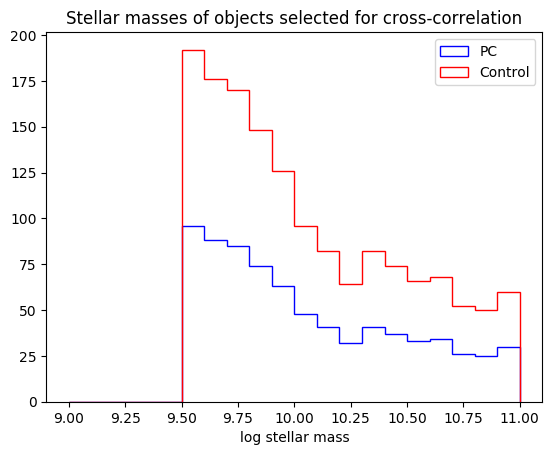

In [4]:
# Match stellar mass distributions using histogram
fig, ax = plt.subplots()
binsize=0.1
bins_fine = np.arange(9.,11.+binsize, binsize)
hist_mstar_pc, bins_out, patches_out =ax.hist(lgsmass_pcg, bins=bins_fine, histtype='step', 
                      fill=False, color='blue', label='PC', normed=False)
#hist_mstar_nonpc=ax.hist(lgsmass_feld, bins=bins_fine, histtype='step', 
#                         fill=False, color='green', label='non-PC', normed=False)
ax.set_xlabel('log stellar mass')
ax.set_title('Stellar masses of objects selected for cross-correlation')

multi_ctrl = 2. # This is how big control sample is relative to the PC galaxies
ind_ctrl = np.asarray([])
for htmp,binlo,binhi in zip(hist_mstar_pc, bins_out[0:-1], bins_out[1:]):
    getctrl = np.squeeze(np.where((lgsmass_feld >= binlo) & 
                                         (lgsmass_feld< binhi)))
    if len(getctrl) > 0:
        subsamp = np.random.choice(len(getctrl),int(htmp*multi_ctrl), replace=False)
        ind_ctrl = np.append(ind_ctrl, getctrl[subsamp])

ind_ctrl = np.ndarray.astype(ind_ctrl, dtype=int)
        
hist_mstar_ctrl=ax.hist(lgsmass_feld[ind_ctrl], bins=bins_fine, histtype='step', 
                         fill=False, color='red', label='Control', normed=False)
    
plt.legend()
plt.show()

#pcsamp = np.random.choice(len(ind_pcgal), ngal_pc, replace=False)
#ctrlsamp= np.random.choice(len(ind_ctrl), ngal_pc, replace=False)

pcsamp = np.arange(len(ind_pcgal))
ctrlsamp = np.arange(len(ind_ctrl))

coord_ctrl = SkyCoord(ra=ra_gal[ind_ctrl[ctrlsamp]]*u.degree, 
                      dec=dec_gal[ind_ctrl[ctrlsamp]]*u.degree,
                     distance=cosmo.comoving_distance(red_gal[ind_ctrl[ctrlsamp]]))
coord_pc = SkyCoord(ra=ra_pcg[pcsamp]*u.degree, 
                    dec=dec_pcg[pcsamp]*u.degree,
                    distance=cosmo.comoving_distance(red_pcg[pcsamp]))

Evaluating cross-correlation for 1506 galaxies and 1460000 forest pixels
2D histogram evaluation took 0.174171 seconds for first galaxy
Finished evaluating cross-correlations. This took 262.718875 seconds
0 galaxies had no cross-correlations within these bins.
Evaluating cross-correlation for 753 galaxies and 1460000 forest pixels
2D histogram evaluation took 0.179102 seconds for first galaxy
Finished evaluating cross-correlations. This took 130.378765 seconds
0 galaxies had no cross-correlations within these bins.


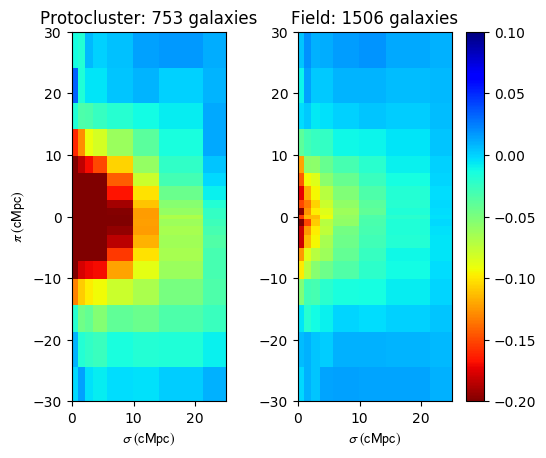

In [5]:
XCorr_ctrl, NoXCorr_ctrl = xcorr.xcorr_gal_lya(coord_ctrl, lyapix, SigEdges, 
                                           PiEdges, cosmo=cosmo)
XCorr_pc, NoXCorr_pc = xcorr.xcorr_gal_lya(coord_pc, lyapix, SigEdges, 
                                           PiEdges, cosmo=cosmo)

X, Y = np.meshgrid(SigEdges, PiEdges)

XCorrArr1 = np.rot90(XCorr_pc)
XCorrArr1 = np.flipud(XCorrArr1)

XCorrArr2 = np.rot90(XCorr_ctrl)
XCorrArr2 = np.flipud(XCorrArr2)

fig, (ax1,ax2) = plt.subplots(1,2)
SigMax = 25.
PiMin = -30.
PiMax = 30.

pcm=ax1.pcolormesh(X, Y, XCorrArr1,cmap='jet_r',vmin=-0.2, vmax=0.1 )
ax1.set_aspect('equal')
ax1.set_xlim(np.min(X), SigMax)
ax1.set_ylim(PiMin, PiMax)
ax1.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax1.set_ylabel(r'$\pi\; (\mathrm{cMpc})$')
ax1.set_title("Protocluster: %i galaxies" % len(coord_pc))

ax2.pcolormesh(X, Y, XCorrArr2, cmap='jet_r',vmin=-0.2,vmax=0.1)
ax2.set_aspect('equal')
ax2.set_xlim(np.min(X), SigMax)
ax2.set_ylim(PiMin, PiMax)
ax2.set_xlabel(r'$\sigma\; (\mathrm{cMpc})$')
ax2.set_title("Field: %i galaxies" % len(coord_ctrl))

fig.colorbar(pcm, ax=ax2)
fig.subplots_adjust(wspace=-0.2)

plt.show()

[ 2.34003774  2.70809446  2.92770269  3.3122515   3.51713406  3.52381833
  3.51729428 10.24184143  1.        ]


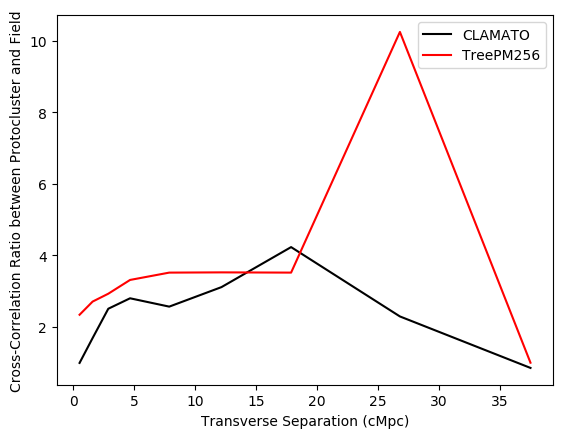

In [12]:
# Compute the ratio of the protocluster cross-correlation vs field. Null out 
# the underdensities to 

XCorrArr1_tmp = np.copy(XCorrArr1)
XCorrArr2_tmp = np.copy(XCorrArr2)
dodgybin = (XCorrArr1_tmp > 0.) | (XCorrArr2_tmp > 0.)

XCorrRatio = XCorrArr1_tmp/XCorrArr2_tmp

XCorrRatio[dodgybin] = 1.

i_Pi_stack = np.asarray([10,11,12,13,14])-1

XCorrRatio_stack = np.sum(XCorrRatio[i_Pi_stack], axis=0)/len(i_Pi_stack)

print(XCorrRatio_stack)

#This is just copied over from XCorr_Protocluster and should be regarded as sketchy as hell
XCorrRatio_stack_cl = np.asarray([0.9938307 , 1.68977379, 2.50807204, 2.799842  , 2.56687358,
                       3.11175943, 4.22989332, 2.29263562, 0.85432321])

SigCen = np.empty(np.size(SigEdges)-1)
for i, Sig in enumerate(SigCen):
    SigCen[i] = (SigEdges[i] + SigEdges[i+1])/2.
    
fig, ax = plt.subplots()

ax.plot(SigCen, XCorrRatio_stack_cl, label='CLAMATO', color='black')
ax.plot(SigCen, XCorrRatio_stack, label='TreePM256', color='red')

ax.set_xlabel('Transverse Separation (cMpc)')
ax.set_ylabel('Cross-Correlation Ratio between Protocluster and Field')

ax.legend()

plt.show()